In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
import lightgbm as lgb
from utils.utils import _down_cast, data_preprocessing, diff_lists, log_status
from utils.utils import ensemble_submissions, ensemble_submissions_uncertainty
from utils.metrics import WSPL
from utils.configure_logger import configure_logger
from utils.utils import prefixes_in_column
from utils import constants

configure_logger()
from logging import getLogger
logger = getLogger(__name__)

import warnings
warnings.simplefilter("ignore")

In [2]:
DATA_BASE_PATH = constants.DATA_BASE_PATH #'../data/m5-forecasting-accuracy/'
DATA_BASE_PATH_UNCERTAINTY = constants.DATA_BASE_PATH_UNCERTAINTY #'../data/m5-forecasting-uncertainty/'
SALES_EVALUATION = constants.SALES_EVALUATION 
SALES_VALIDATION = constants.SALES_VALIDATION
CALENDAR = constants.CALENDAR 
SAMPLE_SUBMISSION = constants.SAMPLE_SUBMISSION 
SELL_PRICES = constants.SELL_PRICES

PRECOMPUTED_BASE_PATH = constants.PRECOMPUTED_BASE_PATH #'../data/uncertainty/features/'

DAYS: int = constants.DAYS #28
QUANTILES: int = constants.QUANTILES 

AGG_LEVEL_COLUMNS = constants.AGG_LEVEL_COLUMNS
D_CROSS_VAL_START_LIST = constants.D_CROSS_VAL_START_LIST

# to simple get the precomputed name
precomputed_name = lambda store, eval_val: f'processed_{store}_{eval_val}.pkl'

TEST_PATH = constants.TEST_PATH#'test/'
PREDICTION_BASE_PATH = constants.PREDICTION_BASE_PATH #'../data/uncertainty/temp_submissions/'
SUBMISSION_BASE_PATH = constants.SUBMISSION_BASE_PATH #'../data/uncertainty/final_submissions/'

SUB_D_START_VAL: int = constants.SUB_D_START_VAL
SUB_D_START_EVAL: int = constants.SUB_D_START_EVAL

# the columns are always included after feature processing
# because they are required in the training and submission format
DROP_FEATURE_COLUMNS: list = constants.DROP_FEATURE_COLUMNS #['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'sold']

### Define GridSearch functions

In [44]:
@log_status
def grid_search(params: dict, param_grid: dict, features, targets, n_folds: int = 1):
    """ 
    Given a grid with parameters, train lgb model for all possible combinations.
    Returns the parameter set with the best score and the dictionary with all results.
    """
    import itertools
    
    # to be sure
    features = features.reset_index(drop=True)
    targets = targets.reset_index(drop=True)

    param_combinations = list(itertools.product(*param_grid.values()))
    results = {}
    for i, param_combination in enumerate(param_combinations,1):
        
        # create dictionary with all parameters
        param_combination = {k:v for k,v in zip(param_grid.keys(), param_combination)}
        param_combination.update(params)
                
        # init dict
        results[f"combination_{i}"] = {
            'params': param_combination,
            'res': []
        }
        
        # perform n_folds
        for j in range(n_folds):
            
            # kfold
            features_train, features_validation, targets_train, targets_validation =\
                train_test_split(features, targets, train_size = .8, shuffle=True)#, random_state=42)

            # train lgb model        
            temp_dict = {} # this dict object will be used to add all (intermediate) evaluation scores during the training process
            mod: lgb.Booster = lgb.train(param_combination, 
                train_set = lgb.Dataset(features_train, targets_train),
                valid_sets = lgb.Dataset(features_validation, targets_validation),
                evals_result = temp_dict,
                verbose_eval=False
            )
            
            # store results
            results[f"combination_{i}"]['res']\
                .append(temp_dict["valid_0"]["quantile"][-1],
                )

        # compute average results
        results[f"combination_{i}"]['validation_score'] = \
            np.mean(results[f"combination_{i}"]['res'])
            
        # REMOVE
        p = results[f"combination_{i}"]['params']
        logger.info(f"{p['learning_rate']} - {p['num_leaves']} - {p['n_estimators']}" + ' - score: ' + str(np.mean(results[f"combination_{i}"]['res'])) + ' ' + str(np.std(results[f"combination_{i}"]['res'])))
        # REMOVE
        
    # sort the results based on evaluation score
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1]["validation_score"]))
    return list(sorted_results.values())[0], results

In [45]:
class LoadData:
    """ Class to load data """
    def __init__(self):
        self.level = None
        
    def prep_data(self,level, sub_d_start):
        """ read the precomputed features and targets for specified aggregation level,  """
        # define params
        agg_level = level
        # sub_d_start: int = int(1886)
        exclude_columns = []
        test = False
        type_of = 'val'

        # read file
        agg_columns = AGG_LEVEL_COLUMNS[agg_level]
        if len(agg_columns) == 0:
            agg_str: str = 'Total_X'
        elif len(agg_columns) == 1:
            agg_str: str = f'{agg_columns[0]}_X'
        else:
            agg_str: str = '_'.join(agg_columns)

        if self.level == level:
            pass
        else:
            logger.info('(re)loading features')
            features = pd.read_parquet(f'../data/uncertainty/fold_{sub_d_start}/features/' + (TEST_PATH if test else '') + f'features_{type_of}_{agg_str}.parquet')
            features = _down_cast(features)

        group_columns = agg_columns
        exclude_prefix_list = exclude_columns # unconditional, auto, momentum, seasonal
        
        features_gr = features.copy()
        features_gr = features_gr[[c for c in features_gr if c.split('_')[0] not in exclude_prefix_list]]

        # preparations
        train_idx = features_gr['sold'].notna() & features_gr['d'].isin([f'd_{sub_d_start - 1 - i}' for i in range(1460)])
        df_train = features_gr[train_idx]
        features_train: pd.DataFrame = df_train.drop(DROP_FEATURE_COLUMNS, axis = 1, errors = 'ignore')
        targets_train: pd.Series = df_train['sold']
        return features_train, targets_train

### Test Training a Single Model

In [46]:
# load data example, to investigate which features are computed, among other things
level = 'Level2'
dataLoader = LoadData()
features, targets = dataLoader.prep_data(level, 1914)
# list(features.columns)

2023-12-20 19:45:16 - __main__ - INFO - (re)loading features


In [47]:
# kfold
prefixes = ['seasonal', 'auto_sold_ewm']
features_train, features_validation, targets_train, targets_validation =\
    train_test_split(features, targets, test_size = 28, shuffle=False, random_state=42)
    # train_test_split(features[[c for c in features.columns if prefixes_in_column(c, prefixes)]], targets, train_size = .8, shuffle=False, random_state=42)

params = {
    'objective': 'quantile',
    # 'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
    'boosting_type': 'gbdt',
    'random_state': 43,
    'verbose': -100,
    'n_jobs': 4,
    # 'subsample': .9,
    # 'subsample_freq': 1,
    "num_leaves": 30,
    "min_child_weight": .1,
    "min_child_samples": 4,
    "hist_pool_size": 1000,
    'feature_fraction': 0.9, #.5
    # 'bagging_fraction': .8,
    "learning_rate": 0.005, #0.07,
    "n_estimators": 2000,#100
    "max_depth": 10,
    # 'reg_sqrt': True,
    # 'req_lambda': .00001,
    # 'reg_alpha': .00001,
    'alpha': .25,
    'verbose': 0
}

# # train lgb model       
# for q in [0.005, 0.025, 0.135, 0.25, 0.5, 0.75, 0.865, 0.975, 0.995]:
#     params['alpha'] = q 
#     temp_dict = {}
#     mod: lgb.Booster = lgb.train(params, 
#         train_set = lgb.Dataset(features_train, targets_train),
#         valid_sets = lgb.Dataset(features_validation, targets_validation),
#         evals_result = temp_dict,
#         verbose_eval = False
#     )
#     plt.plot(mod.predict(features_validation), label = f'{q}')

# plt.scatter(range(len(targets_validation.index)), targets_validation, label = 'true', s = 10)
# plt.legend()
# plt.grid()
# plt.show()

### Test Run for Grid Search

In [48]:
# total ~280 seconds
lgb_quantile_params = {     # fairly well tuned, with high runtimes 
    'max_depth': [10, 20],
    'n_estimators': [ 150, 200, 200],  # 300, 350, 400, ],   
    'min_split_gain': [0, 0, 0, 0, 1e-4, 1e-3, 1e-2, 0.1],
    'min_child_samples': [ 2, 4, 7, 10, 14, 20, 30, 40, 60, 80, 100, 100, 100, 
                                        130, 170, 200, 300, 500, 700, 1000 ],
    'min_child_weight': [0, 0, 0, 0, 1e-4, 1e-3, 1e-3, 1e-3, 5e-3, 2e-2, 0.1 ],
    'num_leaves': [ 20, 30, 50, 50 ], # 50, 70, 90, ],
    'learning_rate': [  0.04, 0.05, 0.07, 0.07, 0.07, 0.1, 0.1, 0.1 ],   # 0.02, 0.03,        
    'colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9, 0.9, 0.9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
    'colsample_bynode':[0.1, 0.15, 0.2, 0.2, 0.2, 0.25, 0.3, 0.5, 0.65, 0.8, 0.9, 1],
    'reg_lambda': [0, 0, 0, 0, 1e-5, 1e-5, 1e-5, 1e-5, 3e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100   ],
    'reg_alpha': [0, 1e-5, 3e-5, 1e-4, 1e-4, 1e-3, 3e-3, 1e-2, 0.1, 1, 1, 10, 10, 100, 1000,],
    'subsample': [  0.9, 1],
    'subsample_freq': [1],
    'cat_smooth': [0.1, 0.2, 0.5, 1, 2, 5, 7, 10],
}

params = {
    'objective': 'quantile',
    # 'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
    'boosting_type': 'gbdt',
    'random_state': 43,
    'verbose': -1,
    'n_jobs': 4,
    # 'eval_at': 10,
    'hist_pool_size': 1000,
    # 'verbose_eval': 0
    # 'subsample': 0.5,
    # 'subsample_freq': 1,
    # 'feature_fraction': 0.5,
}

param_grid = {
    'max_depth': [10],
    'n_estimators': [200, 800],
    # 'min_split_gain': [0, 0, 0, 0, 1e-4, 1e-3, 1e-2, 0.1],
    'min_child_samples': [4],
    'min_child_weight': [0.1 ],
    'num_leaves': [30], # 50, 70, 90, ],
    'learning_rate': [0.001, 0.005, 0.01 ],   # 0.02, 0.03,        
    # 'colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9, 0.9, 0.9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
    # 'colsample_bynode':[0.1, 0.15, 0.2, 0.2, 0.2, 0.25, 0.3, 0.5, 0.65, 0.8, 0.9, 1],
    # 'reg_lambda': [0, 1e-5, 1e-5, 1e-4, 1e-2, 1, 10, ],
    # 'reg_alpha': [0, 1e-5, 3e-5, 1e-4, 1e-3, 1e-2, 1, 10, 100, 1000,],
    'subsample': [  0.9, 1],
    'subsample_freq': [1],
}

In [49]:
# # test grid search for all quantiles
# for q in QUANTILES[:5]:
    
#     # of course, update quantile in params
#     params['alpha'] = q
#     best_res, res = grid_search(params, param_grid, features_train, targets_train, 1)
#     logger.info(best_res['params'])
    
#     mod = lgb.train(best_res['params'],
#         train_set = lgb.Dataset(features_train, targets_train)
#     )
#     predictions = mod.predict(features_validation)
#     plt.plot(predictions, label = str(q))

# plt.scatter(range(len(targets_validation)), targets_validation)
# plt.legend()
# plt.grid()
# plt.show()

# Train + Predict submission

In [55]:
def train_level_all_quantiles(
    agg_level: str, 
    type_of: str, 
    sub_d_start: int, 
    exclude_columns: list = [], 
    include_columns: list = None,
    test: bool = False, 
    do_grid_search: bool = False, 
    store_submissions_path: str = None, 
    normalize: bool = False,
):
    """ 
    Train, for a specific aggregation level, models for all quantiles.
    For aggregation levels 10, 11 and 12, undersampling is used to drastically reduce training time.
    """
    ALWAYS_KEEP_COLUMNS = ['days_fwd', 'sold', 'd']
    
    agg_columns = AGG_LEVEL_COLUMNS[agg_level]
    if len(agg_columns) == 0:
        agg_str: str = 'Total_X'
    elif len(agg_columns) == 1:
        agg_str: str = f'{agg_columns[0]}_X'
    else:
        agg_str: str = '_'.join(agg_columns)

    # try:
    #     features = pd.DataFrame(features)
    # except Exception:
    # loading features
    logger.info('(re)loading features')
    features = pd.read_parquet(f'../data/uncertainty/fold_{sub_d_start}/features/' + (TEST_PATH if test else '') + f'features_{type_of}_{agg_str}.parquet')
    features = _down_cast(features)
    features_gr = features.copy()
    
    # preparations
    # sub_d_start = SUB_D_START_VAL if type_of == 'val' else SUB_D_START_EVAL
    train_idx = features_gr['sold'].notna() & features_gr['d'].isin([f'd_{sub_d_start - 1 - i}' for i in range(1300)])
    pred_idx = features_gr['d'].isin([f'd_{sub_d_start + i}' for i in range(DAYS)])

    group_columns = agg_columns
    res: list = []
    
    def check_any_prefix_matches(column, prefixes):
        """ Return true if any prefix is in column """
        # print(column, prefixes, prefixes[0] in column)
        for prefix in prefixes:
            if prefix in column:
                return True
        return False

    # select features
    if USE_ALL or 'kbest' in include_columns:
        columns = features_gr.columns
    elif SPARSE_FEATURES:
        columns = [c for c in features_gr.columns if c in SPARSE_FEATURES]
    elif include_columns == None:
        # exclude features from exclusion prefix list
        exclude_prefix_list = exclude_columns 
        # columns = [c for c in features_gr.columns if c.split('_')[0] not in exclude_prefix_list]
        columns = [c for c in features_gr.columns if not check_any_prefix_matches(c, exclude_prefix_list)]
    elif isinstance(include_columns, list):
        include_prefix_list = include_columns
        # columns = [c for c in features_gr.columns if c.split('_')[0] in include_prefix_list]
        columns = [c for c in features_gr.columns if check_any_prefix_matches(c, include_prefix_list)]

    for column in ALWAYS_KEEP_COLUMNS + group_columns:
        if column not in columns:
            columns.append(column) 

    features_gr = features_gr[columns]
    df_pred = features_gr[pred_idx]
    df_train = features_gr[train_idx]
    if agg_level not in ['Level9', 'Level10', 'Level11', 'Level12']:
        df_train = df_train[df_train['sold'] >= 50]

    from copy import deepcopy
    temp_drop_feature_columns = deepcopy(DROP_FEATURE_COLUMNS)
    if not USE_ALL and 'kbest' not in include_columns:
        if 'state_id' in include_prefix_list:
            temp_drop_feature_columns.remove('state_id')
        if 'store_id' in include_prefix_list:
            temp_drop_feature_columns.remove('store_id')
    if USE_ALL or 'kbest' in include_columns:
        temp_drop_feature_columns.remove('state_id')
        temp_drop_feature_columns.remove('store_id')
        
    features_train: pd.DataFrame = df_train.drop(temp_drop_feature_columns, axis = 1, errors = 'ignore')
    # logger.info(f'feature: {str(features_train.columns)}')
    targets_train: pd.Series = df_train['sold']
    features_predict: pd.DataFrame = df_pred.drop(temp_drop_feature_columns, axis = 1, errors = 'ignore')
    targets_test: pd.Series = df_pred['sold']
    
    #### SELECT FEATURES ####
    if 'kbest' in include_columns:
        # cannot do selectkbest for category variables
        exclude_from_kbest = ['state_id', 'store_id', 'seasonal_weekday', 'seasonal_monthday', 'seasonal_month', 'days_fwd']
        # temp_drop_idx = features_train.notna().all(axis=1)
        temp_drop_idx = features_train.drop(exclude_from_kbest, axis=1, errors='ignore').fillna(0).notna().all(axis=1)
        from sklearn import metrics
        from sklearn import feature_selection
        fit = SelectKBest(
                k=5,
                # score_func=metrics.mean_pinball_loss
                score_func=feature_selection.f_regression
            ).fit(
                features_train.drop(exclude_from_kbest, axis=1, errors='ignore').fillna(0)[temp_drop_idx], 
                targets_train[temp_drop_idx]
            )
        # print(fit.get_feature_names_out())
        features_keep = list(fit.get_feature_names_out())
        for c in exclude_from_kbest:
            if c in features_train.columns:
                features_keep.append(c)
        print(features_keep)
        features_train = features_train[features_keep]
        features_predict = features_predict[features_keep]
    #### SELECT FEATURES ####
    
    # undersample data
    if agg_level in undersampling_dict.keys() and HIGH_UNDERSAMPLING:
        undersampling_pct = undersampling_dict[agg_level]
        features_train, _, targets_train, _ = train_test_split(features_train, targets_train, train_size = undersampling_pct, shuffle=True, random_state=43)

    # normalise targets
    if normalize:
        logger.info('scaling targets')
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        targets_train = scaler.fit_transform(targets_train.values.reshape(-1,1))
        
    # REMOVE THIS
    import matplotlib.pyplot as plt
    if PLOT_PREDICTIONS:
        fig, ax = plt.subplots(1,1, figsize = (10,5))
        aaa = [i for i in range(targets_test.shape[0])]
    # REMOVE THIS
        
    # train model for all quantiles
    for quantile in QUANTILES:
        
        # perform grid search for best parameters
        if do_grid_search == True:
            # split data to training and testing
            logger.info('perform gridsearch')
            params['alpha'] = quantile
            best_combination, results = grid_search(params, param_grid, features_train, targets_train, n_folds = 5)
            # del train_data; del validation_data
            params_grid_train = best_combination["params"]
            logger.info(f'q: {quantile} - cv best params: {params_grid_train}')
        else:
            params_grid_train = PARAM_GRID_TRAIN
            params_grid_train['alpha'] = quantile

        # train_best_model
        # logger.info(f'features: {str(features_train.columns)}')
        mod = lgb.train(params_grid_train,
            train_set = lgb.Dataset(features_train, targets_train)
        )
        # save model
        group_names = '_'.join(group_columns)
        if group_names == '':
            group_names = 'Total_X'
        if USE_ALL:
            file_path = f'../data/uncertainty/fold_{str(sub_d_start)}/' + 'models/' + f'lgb_{type_of}_nt_{group_names}_use_all_q={quantile}.joblib'
        elif 'kbest' in include_columns:
            file_path = f'../data/uncertainty/fold_{str(sub_d_start)}/' + 'models/' + f'lgb_{type_of}_nt_{group_names}_include_k_best_q={quantile}.joblib'
        elif SPARSE_FEATURES:
            file_path = f'../data/uncertainty/fold_{str(sub_d_start)}/' + 'models/' + f'lgb_{type_of}_nt_{group_names}_sparse_q={quantile}.joblib' 
        elif include_columns == None:
            exclude_names = 'None' if len(exclude_prefix_list) == 0 else '_'.join(exclude_prefix_list)
            file_path = f'../data/uncertainty/fold_{str(sub_d_start)}/' + 'models/' + f'lgb_{type_of}_nt_{group_names}_exclude_{exclude_names}_q={quantile}.joblib'
        elif isinstance(include_columns, list):
            exclude_names = 'None' if len(include_prefix_list) == 0 else '_'.join(include_prefix_list)
            file_path = f'../data/uncertainty/fold_{str(sub_d_start)}/' + 'models/' + f'lgb_{type_of}_nt_{group_names}_include_{exclude_names}_q={quantile}.joblib'

        import joblib
        joblib.dump(mod, file_path)
        
        predictions = mod.predict(features_predict)
        if normalize:
            predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,)
        
        # REMOVE THIS
        if PLOT_PREDICTIONS:
            ax.plot(aaa, predictions, label = f'{quantile}')
        # REMOVE THIS
        
        # store predictions
        df_p = pd.DataFrame(
            {
                'pred': predictions,
                'd': df_pred['d'],
            }
        )
        df_p['quantile'] = quantile
        df_p['Level'] = agg_level
        df_p['type_of'] = 'validation' if type_of == 'val' else 'evaluation'
        if len(agg_columns) == 0:
            df_p['agg_column1'] = 'Total'
            df_p['agg_column2'] = 'X'
        elif len(agg_columns) == 1:
            df_p['agg_column1'] = df_pred[agg_columns[0]].values
            df_p['agg_column2'] = 'X'
        else:
            df_p['agg_column1'] = df_pred[agg_columns[0]].values
            df_p['agg_column2'] = df_pred[agg_columns[1]].values
            
        df_p = df_p[['Level', 'agg_column1', 'agg_column2', 'd', 'quantile', 'pred', 'type_of']]
        
        res.append(_down_cast(df_p))
        
    # REMOVE THIS
    if PLOT_PREDICTIONS:
        ax.legend()
        ax.grid()
        plt.show()
    # REMOVE THIS
        
    # remove to reduce memory usage asap
    del features
        
    # storing predictions in specified file + folder
    df_sub_val = pd.concat(res)
    group_names = '_'.join(group_columns)
    if group_names == '':
        group_names = 'Total_X'
        
    if USE_ALL:
        file_path = f'../data/uncertainty/fold_{str(sub_d_start)}/' + store_submissions_path + f'lgb_{type_of}_nt_{group_names}_use_all.csv'
    elif 'kbest' in include_columns:
        file_path = f'../data/uncertainty/fold_{str(sub_d_start)}/' + store_submissions_path + f'lgb_{type_of}_nt_{group_names}_include_k_best.csv'
    elif SPARSE_FEATURES:
        file_path = f'../data/uncertainty/fold_{str(sub_d_start)}/' + store_submissions_path + f'lgb_{type_of}_nt_{group_names}_sparse.csv'  
    elif include_columns == None:
        exclude_names = 'None' if len(exclude_prefix_list) == 0 else '_'.join(exclude_prefix_list)
        file_path = f'../data/uncertainty/fold_{str(sub_d_start)}/' + store_submissions_path + f'lgb_{type_of}_nt_{group_names}_exclude_{exclude_names}.csv'
    elif isinstance(include_columns, list):
        exclude_names = 'None' if len(include_prefix_list) == 0 else '_'.join(include_prefix_list)
        file_path = f'../data/uncertainty/fold_{str(sub_d_start)}/' + store_submissions_path + f'lgb_{type_of}_nt_{group_names}_include_{exclude_names}.csv'

    if store_submissions_path:
        df_sub_val.to_csv(file_path, index = False)
        logger.info('saved under: ' + file_path)

In [56]:
EXPERIMENTS_DICT = {
    "seasonal": {
        "BASE": [],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ewm'],
            ['seasonal_weekday','auto_sold_ewm'],
            ['seasonal_monthday','auto_sold_ewm'],
            ['seasonal_weekday','seasonal_monthday','auto_sold_ewm'],
            ['seasonal','auto_sold_ewm'],
        ]
    },
    "state vs. store": {
        "BASE": ['seasonal', 'auto_sold_ma'],
        "INCLUDE_COLUMNS_LIST": [
            [],
            ['state_id',],
            ['store_id',],
            ['state_id', 'store_id']
        ]
    },
    "ewm vs. ma": {
        "BASE": ['seasonal'],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ewm'],
            ['auto_sold_ma'],
            ['auto_sold_ewm', 'auto_sold_ma'],
        ]
    },
    "quantiles vs. std": {
        "BASE": ['seasonal', 'auto_sold_ma'],
        "INCLUDE_COLUMNS_LIST": [
            [],
            ['auto_sold_qtile'],
            ['auto_sold_std'],
            ['auto_sold_qtile','auto_sold_std'],   
        ]
    },
    "price auto/momentum": {
        "BASE": ['seasonal', 'auto_sold_ma'],
        "INCLUDE_COLUMNS_LIST": [
            [],
            ['price_auto_std'],
            ['price_momentum'],
            ['price_uncond'],
            ['price_auto_std', 'price_momentum'],
            ['price_auto_std', 'price_momentum', 'price_uncond']
        ]
    },
    "best models": {
        "BASE": ['seasonal'],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ma', 'state_id', 'store_id'],
            ['auto_sold_ma', 'auto_sold_std', 'state_id', 'store_id'],
        ]
    },
    "full vs. sparse ma" : {
        "BASE": ['seasonal'],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ma', 'auto_sold_std', 'auto_sold_qtile', 'auto_sold_ewm', 'state_id', 'store_id'],
            ['auto_sold_ma_28', 'auto_sold_ma_56', 'auto_sold_ma_168', 'state_id', 'store_id']
        ]
    },
    "sparse vs. kbest": {
        "BASE": ['seasonal', 'state_id', 'store_id'],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold', 'price', 'kbest'],
            ['auto_sold_ewm_112', 'auto_sold_ewm_28',
             'auto_sold_qtile_28_0.5', 'auto_sold_ma_28', 
             'auto_sold_qtile_28_0.9',],
        ]
    },
    'full vs. sparse': {
        "BASE": ['seasonal'],
        "INCLUDE_COLUMNS_LIST": [
            ['auto_sold_ma', 'auto_sold_std', 'auto_sold_qtile', 'auto_sold_ewm', 'state_id', 'store_id'],
            ['auto_sold_ma_28', 'auto_sold_ma_56', 'auto_sold_ma_168', 'state_id', 'store_id'],
            ['auto_sold_std_3', 'auto_sold_std_56', 'auto_sold_std_168', 
            'auto_sold_ma_7',  'auto_sold_ma_28', 'auto_sold_ma_56', 
            'auto_sold_qtile_28_0.25', 'auto_sold_qtile_168_0.25', 'auto_sold_qtile_56_0.1', 
            'state_id', 'store_id'],
        ]
    },
}
list(EXPERIMENTS_DICT.keys())

['seasonal',
 'state vs. store',
 'ewm vs. ma',
 'quantiles vs. std',
 'price auto/momentum',
 'best models',
 'full vs. sparse ma',
 'sparse vs. kbest',
 'full vs. sparse']

2023-12-20 21:32:34 - __main__ - INFO - starting with all EXCLUDE_COLUMNS
2023-12-20 21:32:34 - __main__ - INFO - finished all EXCLUDE_COLUMNS
2023-12-20 21:32:34 - __main__ - INFO - ---------------------------------
2023-12-20 21:32:34 - __main__ - INFO - starting with all INCLUDE_COLUMNS
2023-12-20 21:32:34 - __main__ - INFO - Include columns: ['seasonal', 'auto_sold_ewm']
2023-12-20 21:32:34 - __main__ - INFO - starting with agg_level: Level1
2023-12-20 21:32:34 - __main__ - INFO - (re)loading features
2023-12-20 21:32:34 - __main__ - INFO - perform gridsearch
2023-12-20 21:32:34 - grid_search - INFO - calling


[LightGBM] [Warning] Unknown parameter: verbose_eval


2023-12-20 21:32:34 - __main__ - INFO - 0.001 - 10 - 200 - score: 69.98473773420362 5.338744915933145
2023-12-20 21:32:34 - __main__ - INFO - 0.005 - 10 - 200 - score: 69.70822717198675 6.708542702227735
2023-12-20 21:32:35 - __main__ - INFO - 0.01 - 10 - 200 - score: 83.22545795708727 21.001754320945814
2023-12-20 21:32:35 - __main__ - INFO - 0.02 - 10 - 200 - score: 71.1603218117206 6.9333237113242
2023-12-20 21:32:36 - __main__ - INFO - 0.001 - 30 - 200 - score: 73.2078736051174 12.869318908082045
2023-12-20 21:32:36 - __main__ - INFO - 0.005 - 30 - 200 - score: 64.08475929793329 4.638862998673051
2023-12-20 21:32:36 - __main__ - INFO - 0.01 - 30 - 200 - score: 72.04248584898349 10.382114151671715
2023-12-20 21:32:37 - __main__ - INFO - 0.02 - 30 - 200 - score: 71.95370793166626 20.914882216778874
2023-12-20 21:32:37 - __main__ - INFO - 0.001 - 90 - 200 - score: 62.565479652227545 1.4780250467702791
2023-12-20 21:32:38 - __main__ - INFO - 0.005 - 90 - 200 - score: 77.83150512820285 

[LightGBM] [Warning] Unknown parameter: verbose_eval


2023-12-20 21:34:09 - __main__ - INFO - 0.001 - 10 - 200 - score: 275.0279164539011 12.593759119711327
2023-12-20 21:34:10 - __main__ - INFO - 0.005 - 10 - 200 - score: 244.39325712895737 11.713424891651316
2023-12-20 21:34:10 - __main__ - INFO - 0.01 - 10 - 200 - score: 240.5160138173281 36.74560656128261
2023-12-20 21:34:11 - __main__ - INFO - 0.02 - 10 - 200 - score: 217.48208019236682 52.87809052768971
2023-12-20 21:34:11 - __main__ - INFO - 0.001 - 30 - 200 - score: 281.55287896144 30.611867829823968
2023-12-20 21:34:12 - __main__ - INFO - 0.005 - 30 - 200 - score: 241.65136815564702 8.204621087621229
2023-12-20 21:34:13 - __main__ - INFO - 0.01 - 30 - 200 - score: 216.1442705705018 19.00768312106307
2023-12-20 21:34:13 - __main__ - INFO - 0.02 - 30 - 200 - score: 179.85455097729337 15.158224221436852
2023-12-20 21:34:14 - __main__ - INFO - 0.001 - 90 - 200 - score: 273.9398452486785 15.151855227453764
2023-12-20 21:34:15 - __main__ - INFO - 0.005 - 90 - 200 - score: 242.274643079

[LightGBM] [Warning] Unknown parameter: verbose_eval


2023-12-20 21:36:57 - __main__ - INFO - 0.001 - 10 - 200 - score: 1173.767343099289 54.20042016877397
2023-12-20 21:36:57 - __main__ - INFO - 0.005 - 10 - 200 - score: 931.5454592135063 43.84626397002443
2023-12-20 21:36:58 - __main__ - INFO - 0.01 - 10 - 200 - score: 747.6595398271268 58.75217488693823
2023-12-20 21:36:59 - __main__ - INFO - 0.02 - 10 - 200 - score: 608.5098266701661 18.95672574994793
2023-12-20 21:37:00 - __main__ - INFO - 0.001 - 30 - 200 - score: 1181.2851036584084 66.07194052804681
2023-12-20 21:37:01 - __main__ - INFO - 0.005 - 30 - 200 - score: 871.0909384048452 31.89568235484538
2023-12-20 21:37:02 - __main__ - INFO - 0.01 - 30 - 200 - score: 640.4229421007311 27.449076634712483
2023-12-20 21:37:03 - __main__ - INFO - 0.02 - 30 - 200 - score: 566.226383007109 59.83472031088985
2023-12-20 21:37:04 - __main__ - INFO - 0.001 - 90 - 200 - score: 1212.8225701988795 59.4969435454505
2023-12-20 21:37:05 - __main__ - INFO - 0.005 - 90 - 200 - score: 836.8196497936093 4

KeyboardInterrupt: 

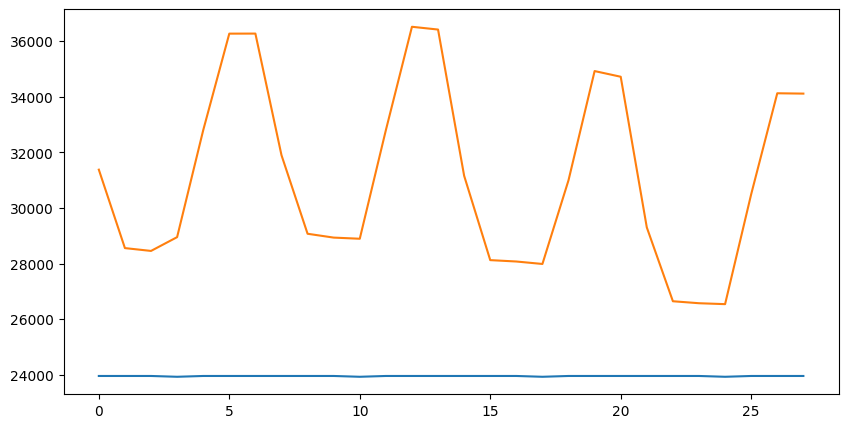

In [58]:
# SPARSE_FEATURES = [ 'seasonal_weekday', 'seasonal_monthday', 'auto_sold_ewm_112', 'auto_sold_ewm_28',
#   'autoquantiles_sold_qtile_28_0.5', 'auto_sold_ma_28',
#   'auto_sold_qtile_28_0.9',
#    'auto_sold_qtile_28_0.1'
# ],

USE_ALL = False
SPARSE_FEATURES = None
PLOT_PREDICTIONS = True

undersampling_dict = {
    'Level10': .1, #.001
    'Level11': .1, #.0001
    'Level12': .1 #.00001
}

HIGH_UNDERSAMPLING = True
TEST_NUMBER = 9 # 9
TEST_NUMB = 0 # 0
PARAM_GRID_TRAIN = {
    'objective': 'quantile',
    'boosting_type': 'gbdt',
    'random_state': 43,
    'verbose': -1,
    'n_jobs': 4,
    "num_leaves": 10, # 30
    "hist_pool_size": 300,
    "learning_rate": .01, # .01
    "n_estimators": 1000, #1000
    "max_depth": 10, #10
}
PARAM_GRID_TRAIN_HIGH_LEVEL = {
    'objective': 'quantile',
    # 'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
    'boosting_type': 'gbdt',
    'random_state': 43,
    'verbose': -1,
    'n_jobs': 4,
    "num_leaves": 30,
    "hist_pool_size": 300,
    # 'feature_fraction': 0.9, #.5
    # 'bagging_fraction': .8,
    "learning_rate": .01, # .01 always
    "n_estimators": 3000, # 3000 always
    "max_depth": 10,
}

params = {
    'objective': 'quantile',
    # 'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
    'boosting_type': 'gbdt',
    'random_state': 43,
    'verbose': -100,
    'n_jobs': 4,
    # 'eval_at': 10,
    'hist_pool_size': 300,
    'verbose_eval': -100,
}
param_grid = {
    'max_depth': [10,],
    'n_estimators': [200, 500, 1000, 2000],
    # 'min_child_samples': [4],
    # 'min_child_weight': [0,0.1],
    'num_leaves': [10, 30, 90], # 50, 70, 90, ],
    'learning_rate': [.001, .005, .01, .02],#[0.04, 0.07, 0.1],   # 0.02, 0.03,        
    # 'subsample': [ 0.9, 1 ],
    # 'subsample_freq': [1],
}

# ALL_PREFIXES = ['auto_sold', 'auto_sold_ma', 'auto_sold_std', 'auto_sold_ewm', 'auto_sold_qtile',
#     'price_momentum', 'price_uncond', 'price_auto_std','seasonal_', 'state_', 'store_',
# ]

experiment_name = 'seasonal'
experiment_specs = EXPERIMENTS_DICT[experiment_name]
BASE = experiment_specs['BASE']
INCLUDE_COLUMNS_LIST = experiment_specs['INCLUDE_COLUMNS_LIST']

INCLUDE_COLUMNS_LIST = [BASE + i for i in INCLUDE_COLUMNS_LIST]
DO_GRID_SEARCH = True

EXCLUDE_COLUMNS_LIST = ()
logger.info('starting with all EXCLUDE_COLUMNS')
for exclude_columns in EXCLUDE_COLUMNS_LIST: # for each specified feature combination
    logger.info(f'Exclude columns: {str(exclude_columns)}')
    for sub_d_start in D_CROSS_VAL_START_LIST:
        for agg_level in list(AGG_LEVEL_COLUMNS.keys())[TEST_NUMB:TEST_NUMBER]: # for each aggregation level
            logger.info(f'starting with agg_level: {agg_level}')
            train_level_all_quantiles(
                agg_level,
                sub_d_start=sub_d_start,
                type_of='val', 
                exclude_columns=exclude_columns,
                do_grid_search=DO_GRID_SEARCH,
                store_submissions_path=None#'temp_submissions/',
            )
logger.info('finished all EXCLUDE_COLUMNS')

logger.info('---------------------------------')            
logger.info('starting with all INCLUDE_COLUMNS')            
for include_columns in INCLUDE_COLUMNS_LIST[-1:]: # for each specified feature combination
    logger.info(f'Include columns: {str(include_columns)}')
    for sub_d_start in D_CROSS_VAL_START_LIST:
        for agg_level in list(AGG_LEVEL_COLUMNS.keys())[TEST_NUMB:TEST_NUMBER]: # for each aggregation level
            logger.info(f'starting with agg_level: {agg_level}')
            train_level_all_quantiles(
                agg_level,
                sub_d_start=sub_d_start,
                type_of='val', 
                exclude_columns=None,
                include_columns=include_columns,
                do_grid_search=DO_GRID_SEARCH,
                store_submissions_path=None#'temp_submissions/',
            )
logger.info('finished all INCLUDE_COLUMNS')

### Load val + eval prediction files and merge to one submission file

In [48]:
# exclude_columns = '_'.join([])
# if exclude_columns == '':
#     exclude_columns = 'None'

# dfs: list = []
# for level in AGG_LEVEL_COLUMNS:
#     agg_columns = AGG_LEVEL_COLUMNS[level]
#     group_names = '_'.join(agg_columns)
#     if group_names == '':
#         group_names = 'Total_X'
#     i = str(1914)
#     dfs.append(
#         f'../data/uncertainty/fold_{i}/temp_submissions/' + f'lgb_multivariate_val_non_transposed_{group_names}_exclude_{exclude_columns}.csv',
#     )

# df_sub_val = ensemble_submissions_uncertainty(dfs)
# transpose = True
# if transpose == True:
#     sub_validation = df_sub_val.pivot(index='id', columns='d', values='pred').reset_index(drop=False)
#     sub_validation.columns = ["id"] + [f"F{i}" for i in range(1,DAYS+1)]

In [ ]:
def read_concat_predictions(fold_name: int, exclude_columns: list = [], include_columns: list = [], sparse = False, use_all = False, load_submissions_path: str = 'temp_submissions/'):
    """ 
    For specified fold, read the predictions for all aggregation levels and stack them together in one dataframe.
    """
    # D_CV_START_LIST
    # if fold_name not in D_CV_START_LIST:
        # raise ValueError('fold_name must be a value in D_CV_START_LIST')
        
    exclude_columns = '_'.join(exclude_columns)
    if exclude_columns == '':
        exclude_columns = 'None'

    logger.info('loading files under path:' + f'../data/uncertainty/fold_{fold_name}/' + load_submissions_path)

    dfs: list = []
    for level in list(AGG_LEVEL_COLUMNS.keys())[TEST_NUMB:TEST_NUMBER]:
        agg_columns = AGG_LEVEL_COLUMNS[level]
        group_names = '_'.join(agg_columns)
        if group_names == '':
            group_names = 'Total_X'
        
        file_path = f'../data/uncertainty/fold_{str(fold_name)}/' + load_submissions_path 
        file_path += f'lgb_val_nt_{group_names}_'
        if use_all:
            file_path += f'use_all.csv'  
        elif include_columns == None:
            file_path += f'exclude_{"_".join(exclude_columns)}.csv'            
        elif isinstance(include_columns, list):
            file_path += f'include_{"_".join(include_columns)}.csv'
        
        dfs.append(file_path)
    return ensemble_submissions_uncertainty(dfs)

In [ ]:
# BASE = ['seasonal',]
# INCLUDE_COLUMNS_LIST = [
#     # ['auto_sold_ma', 'auto_sold_std', 'auto_sold_qtile', 'auto_sold_ewm', 'state_id', 'store_id'],
#     ['auto_sold_std_3', 'auto_sold_std_56', 'auto_sold_std_168', 
#      'auto_sold_ma_7',  'auto_sold_ma_28', 'auto_sold_ma_56', 
#      'auto_sold_qtile_28_0.25', 'auto_sold_qtile_168_0.25', 'auto_sold_qtile_56_0.1', 
#      'state_id', 'store_id'],
#     # ['kbest']
# ]
# 
# BASE = ['seasonal']
# INCLUDE_COLUMNS_LIST = [
#     ['auto_sold_ma', 'auto_sold_std', 'auto_sold_qtile', 'auto_sold_ewm', 'state_id', 'store_id'],
#     ['auto_sold_ma_28', 'auto_sold_ma_56', 'auto_sold_ma_168', 'state_id', 'store_id']
# ]

# include_columns = BASE + INCLUDE_COLUMNS_LIST[1]
# include_columns_str = '_'.join(include_columns)

# dfs: list = []
# for level in AGG_LEVEL_COLUMNS:
#     agg_columns = AGG_LEVEL_COLUMNS[level]
#     group_names = '_'.join(agg_columns)
#     if group_names == '':
#         group_names = 'Total_X'
        
#     dfs.append(
#         f'../data/uncertainty/fold_{1914}/temp_submissions/lgb_val_nt_{group_names}_include_{include_columns_str}.csv'
#     )

# df_sub_eval = ensemble_submissions_uncertainty(dfs)
# transpose = True
# if transpose == True:
#     sub_evaluation = df_sub_eval.pivot(index='id', columns='d', values='pred').reset_index(drop=False)
#     sub_evaluation.columns = ["id"] + [f"F{i}" for i in range(1,DAYS+1)]

# sub_evaluation2 = sub_evaluation.copy()
# sub_evaluation2['id'] = sub_evaluation2['id'].str.removesuffix('_validation') + '_evaluation'
# 
# pd.concat([sub_evaluation, sub_evaluation2]).to_csv('../data/uncertainty/fold_1914/final_submissions/' + f'submission_lgb_ensemble{exclude_columns}.csv', index=False)

In [ ]:
# sub_evaluation = pd.read_csv('../submissions/submission_baseline_evaluation.csv').drop(['Unnamed: 0'], axis=1)
# pd.concat([sub_validation, sub_evaluation]).to_csv(SUBMISSION_BASE_PATH + f'submission_lgb_ensemble{exclude_columns}.csv', index=False)

### For Validation Prediction, we can compute WRMSSE locally

In [52]:
# these variables are used later on
FORCE_RELOAD = False
try:
    # simple code to check if variable exists
    d_int + 1
    if FORCE_RELOAD:
        raise Exception()
except:
    # if not, load again
    # takes about 2-3 minutes to reload and parse
    # not the most beautiful method but it works
    d = pd.read_parquet('../data/uncertainty/cv_template/temp.parquet')
    try:
        d_int = pd.read_parquet('../data/uncertainty/cv_template/temp_d_int.parquet')['d_int']
    except:
        d_int = d['d'].apply(lambda x: int(x.split('_')[1]))
        d_int.to_frame('d_int').to_parquet('../data/uncertainty/cv_template/temp_d_int.parquet', index = False)

In [53]:
def perform_cv(df: pd.DataFrame, df_sub: pd.DataFrame):
    
    # to be able to merge
    # df_sub['id_merge'] = df_sub['id'].str.split('.')\
    #     .apply(lambda x: x[0])
    df_sub['id_merge'] = df_sub['id']\
        .apply(lambda x: x.split('.')[0])
    # df_sub['quantile'] = df_sub['id'].str.split('.')\
    #     .apply(lambda x: float('.'.join([x[-2], x[-1].split('_')[0]])))
    df_sub['quantile'] = df_sub['id']\
        .apply(
            lambda x: float(
                '.'.join([
                x.split('.')[-2], 
                x.split('.')[-1].split('_')[0]
                ])
            )
        )

    # merge predictions in cv template
    p = pd.merge(
        df,
        df_sub,
        how='left',
        on=['id_merge', 'd']
    )
    # del df; del df_sub_val
    p['id_merge'] = p['id_merge'].astype(str)

    for c in ['sold', 'revenue']:
        p[c] = p[c].astype(np.float32)
    # d = d[d_int < (D_CV_START + 28)]

    return WSPL(p, [f'd_{i}' for i in range(D_CV_START, D_CV_START + 500)])

In [54]:
FILE_NAME_ALL_RESULTS = '../data/uncertainty/all_results.json'
USE_ALL = False
FOLDER = 'temp_submissions/'

TEST_NUMB = 0
TEST_NUMBER = 9

# load dict to store results in
from utils.utils import load_results_as_json
results = load_results_as_json(FILE_NAME_ALL_RESULTS)

EXCLUDE_COLUMNS_LIST = []
logger.info('start evaluating exclude columns')
for EXCLUDE_COLUMNS in EXCLUDE_COLUMNS_LIST:
    if 'exclude_' + ' '.join(EXCLUDE_COLUMNS) not in results.keys():
        results['exclude_' + ' '.join(EXCLUDE_COLUMNS)] = {}
    logger.info('--------------- ' + str(EXCLUDE_COLUMNS) + ' ---------------')
    res = []
    for D_CV_START in D_CROSS_VAL_START_LIST:
        mean_wspl, res_dict = perform_cv(
            _down_cast(d)[d_int < (D_CV_START + DAYS)], 
            read_concat_predictions(
                fold_name = D_CV_START, 
                exclude_columns = EXCLUDE_COLUMNS,
                include_columns = None,
                use_all=USE_ALL,
                load_submissions_path=FOLDER
            )
        )
        res.append(mean_wspl)
        results['exclude_' + ' '.join(EXCLUDE_COLUMNS)]['fold_' + str(D_CV_START)] = res_dict 
        logger.info(str(D_CV_START) + ' - wspl: ' + str(mean_wspl))

    logger.info(' - mean wspl: ' + str(np.mean(res)) + ' +/- ' + str(np.std(res)))
    logger.info(str(D_CV_START) + ' - raw results: ' + str(res))

logger.info('start evaluating include columns')
for INCLUDE_COLUMNS in INCLUDE_COLUMNS_LIST:
    if 'kbest' in INCLUDE_COLUMNS:
        INCLUDE_COLUMNS = ['k_best']
    if 'include_' + ' '.join(INCLUDE_COLUMNS) not in results.keys():
        results['include_' + ' '.join(INCLUDE_COLUMNS)] = {}
    logger.info('--------------- ' + str(INCLUDE_COLUMNS) + ' ---------------')
    res = []
    for D_CV_START in D_CROSS_VAL_START_LIST:
        mean_wspl, res_dict = perform_cv(
            _down_cast(d)[d_int < (D_CV_START + DAYS)], 
            read_concat_predictions(
                fold_name = D_CV_START, 
                exclude_columns = [], 
                include_columns = INCLUDE_COLUMNS,
                use_all=USE_ALL,
                load_submissions_path=FOLDER
            )
        )
        res.append(mean_wspl)
        results['include_' + ' '.join(INCLUDE_COLUMNS)]['fold_' + str(D_CV_START)] = res_dict 
        logger.info(str(D_CV_START) + ' - wspl: ' + str(mean_wspl))

    logger.info(str(D_CV_START) + ' - mean wspl: ' + str(np.mean(res)) + ' +/- ' + str(np.std(res)))
    logger.info(str(D_CV_START) + ' - raw results: ' + str(res))

from utils.utils import store_results_as_json
store_results_as_json(results, FILE_NAME_ALL_RESULTS)

2023-12-16 21:02:22 - __main__ - INFO - start evaluating exclude columns
2023-12-16 21:02:22 - __main__ - INFO - start evaluating include columns
2023-12-16 21:02:22 - __main__ - INFO - --------------- ['k_best'] ---------------
2023-12-16 21:02:25 - __main__ - INFO - loading files under path:../data/uncertainty/fold_1802/temp_submissions/
2023-12-16 21:02:45 - utils.metrics - INFO - reading weights file
2023-12-16 21:02:45 - utils.metrics - INFO - sorting df on d ...
2023-12-16 21:03:13 - utils.metrics - INFO - entering loop ...
2023-12-16 21:03:19 - utils.metrics - INFO - Level1 - 0.1712239568255422
2023-12-16 21:03:20 - utils.metrics - ERROR - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
2023-12-16 21:03:24 - utils.metrics - ERROR - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
2023-12-16 21:03:41 - utils.metrics - ERROR - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
2023-12-16 21:03:42 - uti

### Code Beneath can be used to create submission template
The submission template can be used to quickly insert your predictions.
It also contains all other (historical) sales to be able to compute the WRMSSE

In [4]:
# sales_validation = pd.read_csv(DATA_BASE_PATH + SALES_VALIDATION)
# sales_evaluation = pd.read_csv(DATA_BASE_PATH + SALES_EVALUATION)
# calendar = pd.read_csv(DATA_BASE_PATH + CALENDAR)
# sell_prices = pd.read_csv(DATA_BASE_PATH + SELL_PRICES)

# df_val, submission_idx_val = data_preprocessing(sales_validation, calendar, sell_prices)
# del sales_validation
# df_eval, submission_idx_eval = data_preprocessing(sales_evaluation, calendar, sell_prices)
# del sales_evaluation

# df_val_after_release = df_val[(df_val.wm_yr_wk > df_val.release)]# & (df_val["sold"].notna())]
# del df_val
# df_eval_after_release = df_eval[(df_eval.wm_yr_wk > df_eval.release)]# & (df_eval["sold"].notna())]
# del df_eval

In [14]:
# dfs = []
# df_eval_after_release['revenue'] = df_eval_after_release['sold'] * df_eval_after_release['sell_price']
# for level in list(AGG_LEVEL_COLUMNS.keys()):
#     c = AGG_LEVEL_COLUMNS[level]
#     logger.info(level)
#     agg_dict = {
#         'sold': 'sum',
#         'revenue': 'sum'
#     }
#     d1 = df_eval_after_release.groupby(c + ['d']).agg(agg_dict).reset_index(drop=False)
#     d = pd.DataFrame({
#         'd': d1['d'],
#         'sold': d1['sold'],
#         'revenue': d1['revenue']
#     })
#     if len(c) == 0:
#         d['agg_column1'] = 'Total'
#         d['agg_column2'] = 'X'
#     elif len(c) == 1:
#         d['agg_column1'] = d1[c[0]]
#         d['agg_column2'] = 'X'
#     else:
#         d['agg_column1'] = d1[c[0]]
#         d['agg_column2'] = d1[c[1]]
#     d['id_merge'] = d['agg_column1'] + '_' + d['agg_column2']
#     d['Level'] = level
#     dfs.append(d[['Level', 'agg_column1', 'agg_column2', 'd', 'sold', 'revenue', 'id_merge']])
# d = pd.concat(dfs)
# d.head(50)
# d.to_parquet('temp.parquet', index=False)